# Analysis of National Energy Intensity Data and Socio-Demographic Factors

## Initialise and load data

In [1]:
import os 
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt

# pysal and esda for GI* 
# (conda install -c conda-forge libpysal esda)
import libpysal
from esda.getisord import G_Local
# Contextily for adding basemaps
import contextily as cx

### Energy intensity data by Local Authority District (LAD)

<AxesSubplot:>

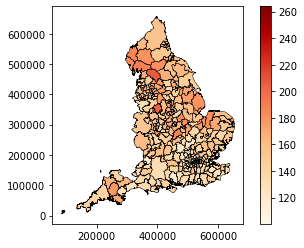

In [2]:
# Read data and make the index the LAD code (allows much easier joining to other data on LAD code)
energy_intensity = gpd.read_file(
    os.path.join("..", "01_Base_Posterior_Sampling/", "Sample_outputs", "energy_intensity_by_lad_since_2000.geojson")).set_index("local_authority", drop=True)

# Drop LSOAs that don't have energy intensity data.
# Note that columns are currently strings, so need to find values with string 'NA',
# not a proper np.nan value.
energy_intensity = energy_intensity.loc[energy_intensity['energy_intensity_mean']!='NA']

# For some reason need to set the numeric columns to be floats 
for col in ['energy_intensity_1stQ', 'energy_intensity_mean',
       'energy_intensity_median', 'energy_intensity_3rdQ',
       'energy_intensity_sd', 'energy_intensity_national_mean',
       'mean_annual_income', 'top_rated_wall_insulation', 'secondary_heating',
       'social_rental', 'private_rental', 'standard_energy_tariff',
       'imd_mean_score',
       'imd_proportion_of_lsoas_in_most_deprived_decile_nationally']:
    # If there are NAs these need to be converted to a proper NA, not a string "NA",
    # otherwise astype() fails
    if (energy_intensity[col]=="NA").any():
        energy_intensity.loc[energy_intensity[col]=="NA", col] = np.nan
    energy_intensity[col] = energy_intensity[col].astype(float)

# Make it British National Grid
energy_intensity = energy_intensity.to_crs("EPSG:27700")

energy_intensity.plot(column="energy_intensity_mean", cmap='OrRd', edgecolor='k', linewidth=0.5, legend=True)

### Demographic data

#### GIS Data

OA/LSOA/MSOA/LAD lookup so that we can move between different geographies.

From [data.gov.uk](https://data.gov.uk/dataset/ec39697d-e7f4-4419-a146-0b9c9c15ee06/output-area-to-lsoa-to-msoa-to-local-authority-district-december-2017-lookup-with-area-classifications-in-great-britain). Download and compress (it's big as a raw csv file) with
```bash
cd data/gis
wget http://geoportal1-ons.opendata.arcgis.com/datasets/fe6c55f0924b4734adf1cf7104a0173e_0.csv
gzip fe6c55f0924b4734adf1cf7104a0173e_0.csv
```

In [3]:
def get_msoa_column(df, lookup, df_col):
    """Return a Series that contains the MSOA code after doing a lookup for an LSOA or OA value
    in df.
    
    :param df: The input OA / LSOA dataframe
    :param lookup: A dict of '(ls)oa_code -> msoa_code'
    :param df_col: The column in df that represents the (LS)OA codes.
    """
    return df[df_col].apply(func=lambda x: lookup[x])

In [4]:
gis_lookup = pd.read_csv(os.path.join('data', 'gis', 'fe6c55f0924b4734adf1cf7104a0173e_0.csv.gz'))

# Make (LS)OA dictionary lookups
oa_dict = gis_lookup.set_index('OA11CD', drop=True).loc[:,'MSOA11CD'].to_dict()
lsoa_dict = gis_lookup.set_index('LSOA11CD', drop=True).loc[:,'MSOA11CD'].to_dict()
# Check the keys are unique (all keys in oa_dict should be different to those in lsoa_dict)
assert len(set(oa_dict.keys()).difference(set(lsoa_dict.keys()))) == len(oa_dict)
# Combine into a single dict
oa_dict.update(lsoa_dict)
msoa_lookup = oa_dict
assert len(msoa_lookup) == len(gis_lookup['OA11CD'].unique()) + len(gis_lookup['LSOA11CD'].unique())

del oa_dict, lsoa_dict

#### Deprivation (IMD)

Index of Multiple Deprivation (IMD) 2019

Source: https://www.gov.uk/government/statistics/english-indices-of-deprivation-2019

See [README.md](./data/imd/README.md) for details.

Note: there is a great infographic that explains the IMD and the diffent domains [here](https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/833959/IoD2019_Infographic.pdf).

In [5]:
imd_lsoa = pd.read_csv(os.path.join("data", "imd", 
                                    "File_2_-_IoD2019_Domains_of_Deprivation.csv.gz"))
imd_lsoa

,LSOA code (2011),LSOA name (2011),Local Authority District code (2019),Local Authority District name (2019),Index of Multiple Deprivation (IMD) Rank (where 1 is most deprived),Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs),Income Rank (where 1 is most deprived),Income Decile (where 1 is most deprived 10% of LSOAs),Employment Rank (where 1 is most deprived),Employment Decile (where 1 is most deprived 10% of LSOAs),"Education, Skills and Training Rank (where 1 is most deprived)","Education, Skills and Training Decile (where 1 is most deprived 10% of LSOAs)",Health Deprivation and Disability Rank (where 1 is most deprived),Health Deprivation and Disability Decile (where 1 is most deprived 10% of LSOAs),Crime Rank (where 1 is most deprived),Crime Decile (where 1 is most deprived 10% of LSOAs),Barriers to Housing and Services Rank (where 1 is most deprived),Barriers to Housing and Services Decile (where 1 is most deprived 10% of LSOAs),Living Environment Rank (where 1 is most deprived),Living Environment Decile (where 1 is most deprived 10% of LSOAs)
0,E01000001,City of London 001A,E09000001,City of London,29199,9,32831,10,32742,10,32842,10,32113,10,32662,10,7319,3,7789,3
1,E01000002,City of London 001B,E09000001,City of London,30379,10,29901,10,31190,10,32832,10,29705,10,32789,10,11707,4,13070,4
2,E01000003,City of London 001C,E09000001,City of London,14915,5,18510,6,15103,5,26386,9,17600,6,29363,9,2157,1,4092,2
3,E01000005,City of London 001E,E09000001,City of London,8678,3,6029,2,7833,3,12370,4,17907,6,31059,10,2217,1,9397,3
4,E01000006,Barking and Dagenham 016A,E09000002,Barking and Dagenham,14486,5,14023,5,21692,7,17511,6,21581,7,18848,6,1033,1,10629,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32839,E01033764,Liverpool 022E,E08000012,Liverpool,116,1,90,1,176,1,565,1,113,1,1688,1,20598,7,14953,5
32840,E01033765,Liverpool 061D,E08000012,Liverpool,945,1,838,1,700,1,1781,1,942,1,3402,2,17379,6,21431,7
32841,E01033766,Liverpool 042G,E08000012,Liverpool,12842,4,16430,6,18004,6,20771,7,5694,2,15832,5,32228,10,778,1
32842,E01033767,Liverpool 050J,E08000012,Liverpool,422,1,442,1,550,1,1208,1,599,1,11728,4,26597,9,915,1


In [6]:
# Aggregate IMD data to local authority district (choose mean rank per LAD for each column)
# And also rename the columns at the same time
# (See https://www.statology.org/pandas-groupby-aggregate-multiple-columns/ for multiple aggregation)

# Define the old and new column names (can axis slice to get old (cols[:,0]) or new (cols[:,1]))
cols = np.array([('Index of Multiple Deprivation (IMD) Rank (where 1 is most deprived)',"IMD_Rank"),
       ('Income Rank (where 1 is most deprived)', "IMD_Income"),
       ('Employment Rank (where 1 is most deprived)', "IMD_Employment"),
       ('Education, Skills and Training Rank (where 1 is most deprived)', "IMD_Education"),
       ('Health Deprivation and Disability Rank (where 1 is most deprived)',"IMD_Health"),
       ('Crime Rank (where 1 is most deprived)',"IMD_Crime"),
       ('Barriers to Housing and Services Rank (where 1 is most deprived)',"IMD_Housing"),
       ('Living Environment Rank (where 1 is most deprived)', "IMD_Environment")])

# Sanity check strings are actually columns names 
assert False not in [col in imd_lsoa.columns for col in cols[:,0] ]

# Rename
imd_lsoa = imd_lsoa.rename(columns={col[0]: col[1] for col in cols})

# Aggregate
imd_lad = imd_lsoa.groupby('Local Authority District code (2019)').agg({col: np.mean for col in cols[:,1]})
del cols  # (just because I use these later and don't want to get confused)

# Merge to the energy data
energy_intensity = energy_intensity.merge(imd_lad, how="left", left_index=True, right_index=True, validate="1:1")
# Sanity check the join (not currently because some areas do not join. Leaving for now)
#assert not energy_intensity[col].isna().any()
energy_intensity.sample(4)

,authority_name,energy_intensity_1stQ,energy_intensity_mean,energy_intensity_median,energy_intensity_3rdQ,energy_intensity_sd,energy_intensity_national_mean,mean_annual_income,top_rated_wall_insulation,secondary_heating,...,imd_proportion_of_lsoas_in_most_deprived_decile_nationally,geometry,IMD_Rank,IMD_Income,IMD_Employment,IMD_Education,IMD_Health,IMD_Crime,IMD_Housing,IMD_Environment
local_authority,,,,,,,,,,,,,,,,,,,,,
E07000034,Chesterfield,121.623274,170.101347,163.406111,211.401795,67.077396,161.618276,25407.0,0.225049,0.244618,...,0.0870,"MULTIPOLYGON (((445642.440 376312.235, 446195....",13778.550725,13433.420290,10943.753623,13972.869565,6507.739130,24071.275362,22517.898551,26261.188406
E07000026,Allerdale,120.772445,185.412747,174.664135,238.080217,88.053203,161.618276,31265.0,0.230126,0.393305,...,0.1167,"MULTIPOLYGON (((317261.918 552470.526, 317260....",15163.966667,17333.883333,15072.916667,13782.250000,14400.083333,21981.766667,18878.116667,13968.600000
E07000243,Stevenage,113.183556,162.960432,155.403359,204.654138,68.677499,161.618276,33776.0,0.090909,0.150776,...,0.0000,"MULTIPOLYGON (((526470.612 226269.134, 526700....",15500.134615,14459.980769,14868.038462,11732.307692,17353.000000,14467.000000,13253.788462,22844.615385
E07000206,Waveney,91.303064,153.544081,141.204233,202.737514,84.243853,161.618276,NaN,NaN,NaN,...,NaN,"MULTIPOLYGON (((650060.141 274529.948, 650053....",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Tenure 

Table [QS405EW](https://www.nomisweb.co.uk/census/2011/qs405ew) (Tenure - Households). 

Used 'Download (.csv)' box at the bottom to download LAD data.

In [7]:
tenure_lad = pd.read_csv(os.path.join("data", "census", "tenure-households-lad.csv")).set_index('geography code', drop=True)

# Merge to the energy data
#XXXX

#### Accommodation (Building) type

Table [QS402EW](https://www.nomisweb.co.uk/census/2011/qs402ew) (Accomodation type). 

Used 'Download (.csv)' box at the bottom to download LAD data.

In [8]:
accommodation_type_lad = pd.read_csv(os.path.join("data", "census", "accommodation-type-lad.csv")).set_index('geography code', drop=True)

# Merge to the energy data
#XXXX

#### Household type

Table [QS116EW](https://www.nomisweb.co.uk/census/2011/qs116ew) - Household type. 

Used 'Download (.csv)' box at the bottom to download LAD data.

In [9]:
building_type_lad = pd.read_csv(os.path.join("data", "census", "household-type-lad.csv")).set_index('geography code', drop=True)

# Merge to the energy data
#XXXX

#### Free school meal eligibility 

From: https://explore-education-statistics.service.gov.uk/find-statistics/free-school-meals-autumn-term/2020-21-autumn-term

In [10]:
fsm_lad = pd.read_csv(os.path.join("data", "free_school_meals", "free-school-meals-autumn-term_2020-21-autumn-term", "data", "fsm_new_starts_autumn20.csv")).set_index('new_la_code', drop=True)
# Drop data that aren't for LADs
fsm_lad = fsm_lad.dropna(subset=['la_name'])
# Each row is a different type of school. Sum the two rows we want across all school types in an LSOA
fsm_lad_grouped = fsm_lad.groupby(fsm_lad.index).agg({"fsm_eligible": np.sum, "headcount": np.sum})
fsm_lad_grouped['fsm_proportion'] = fsm_lad_grouped.fsm_eligible / fsm_lad_grouped.headcount

fsm_lad_grouped.sample(4)

,fsm_eligible,headcount,fsm_proportion
new_la_code,,,
E08000005,34646,147208,0.235354
E09000014,30742,154658,0.198774
E09000007,28892,88776,0.325448
E10000007,83140,431408,0.192718


In [11]:
# Merge 
energy_intensity = energy_intensity.merge(fsm_lad_grouped, how="left", left_index=True, right_index=True)

if len(energy_intensity.loc[energy_intensity.fsm_proportion.isna()]) > 0:
    print(f"Warning, no FSM data found for {len(energy_intensity.loc[energy_intensity.fsm_proportion.isna()])} areas")
    
energy_intensity.sample(4)

Warning, no FSM data found for 203 areas


,authority_name,energy_intensity_1stQ,energy_intensity_mean,energy_intensity_median,energy_intensity_3rdQ,energy_intensity_sd,energy_intensity_national_mean,mean_annual_income,top_rated_wall_insulation,secondary_heating,...,IMD_Income,IMD_Employment,IMD_Education,IMD_Health,IMD_Crime,IMD_Housing,IMD_Environment,fsm_eligible,headcount,fsm_proportion
local_authority,,,,,,,,,,,,,,,,,,,,,
E07000004,Aylesbury Vale,71.425378,121.686195,111.752022,160.806342,68.026061,161.618276,NaN,0.022222,0.177778,...,23854.600000,24682.521739,20701.817391,25630.191304,23203.226087,13122.565217,23076.886957,NaN,NaN,NaN
E07000062,Hastings,92.005141,152.510105,141.446410,200.053320,82.104602,161.618276,23843.0,0.298701,0.121212,...,9164.698113,8817.396226,9737.792453,8943.301887,10440.735849,10151.377358,15484.547170,NaN,NaN,NaN
E07000234,Bromsgrove,123.666036,176.213782,168.679703,220.732631,72.689165,161.618276,32887.0,0.097345,0.339233,...,23152.672414,22137.034483,22878.017241,22295.568966,18013.293103,18300.568966,22841.137931,NaN,NaN,NaN
E06000046,Isle of Wight,82.500985,144.290109,132.009450,192.539495,82.260532,161.618276,26347.0,0.174657,0.147260,...,13389.550562,11384.696629,12046.044944,15053.831461,19170.303371,19024.460674,11583.067416,12264.0,67576.0,0.181485


#### Sub-regional fuel poverty data 2021 
 
https://www.gov.uk/government/statistics/sub-regional-fuel-poverty-data-2021

In [12]:
#XXXX

## Basic correlations

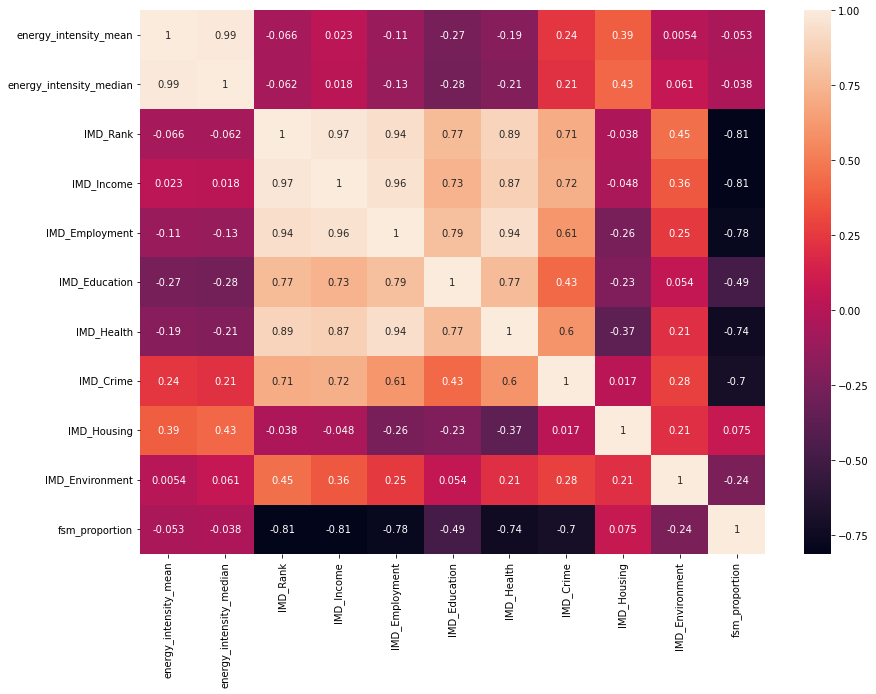

In [14]:
fig, ax = plt.subplots(figsize=(14,10))
cols = ['energy_intensity_mean', 'energy_intensity_median', 'IMD_Rank', 'IMD_Income', 'IMD_Employment', 'IMD_Education', 'IMD_Health', 'IMD_Crime', 'IMD_Housing', 'IMD_Environment', 'fsm_proportion']
sns.heatmap(energy_intensity[cols].corr(), annot=True, ax=ax)
del cols

Have a look at a couple of the correlations in more detail

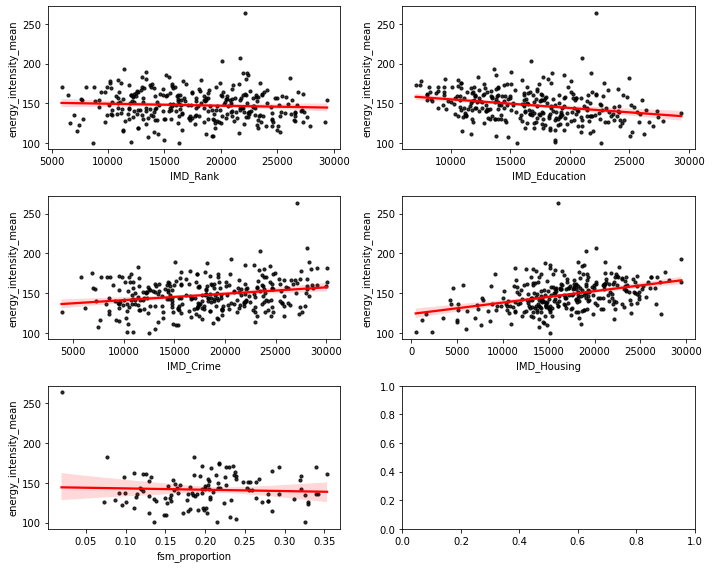

In [15]:
fig, axes = plt.subplots(3,2, figsize=(10,8))
cols = ['IMD_Rank', 'IMD_Education', 'IMD_Crime', 'IMD_Housing', 'fsm_proportion']
yvar = 'energy_intensity_mean'
for ax, col in zip(axes.reshape(-1), cols):
    #ax.scatter(x=col, y=yvar, data=energy_intensity, label=col)
    #ax.set_ylim(0, max(energy_intensity.energy_intensity_mean))
    #ax.set_xlim(0, max(energy_intensity[col]))
    #ax.set_xlabel(col)
    #ax.set_ylabel(yvar)
    sns.regplot(x=energy_intensity[col], y=energy_intensity[yvar], label=col, ax=ax, 
               scatter_kws={'color':'black', 's':10},
               line_kws={'color':'red'}
               )
fig.tight_layout()
del col, cols

## Spatial Analysis

### Local Indicators of Spatial Autocorrelation.

Getis-Ord Local G (G*). See [pysal docs](https://pysal.org/esda/generated/esda.G_Local.html#esda.G_Local). 

References for the method:
 - Arthur Getis and J. K. Ord. The analysis of spatial association by use of distance statistics. Geographical Analysis, 24(3):189–206, Sep 2010. URL: http://dx.doi.org/10.1111/j.1538-4632.1992.tb00261.x
 - J. K. Ord and Arthur Getis. Local spatial autocorrelation statistics: distributional issues and an application. Geographical Analysis, 27(4):286–306, Sep 2010. URL: http://dx.doi.org/10.1111/j.1538-4632.1995.tb00912.x

In [16]:
# Need to temporarily drop isles of scilly and Isle of White because they are disconnected.
# This breaks the calculation of G later
energy_intensity = energy_intensity.drop(['E06000053', 'E06000046'])

/Users/nick/opt/anaconda3/envs/py39/lib/python3.9/site-packages/libpysal/weights/util.py:1073: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  data = np.vstack([np.array(shape.centroid) for shape in first_choice])


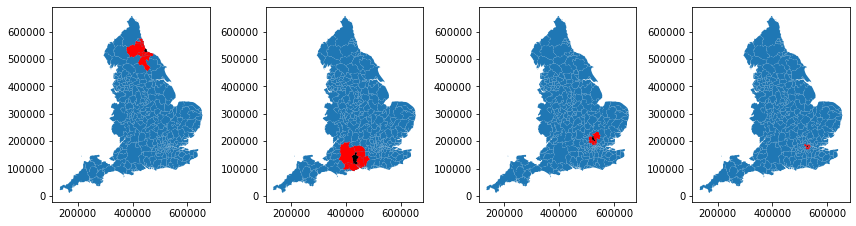

In [17]:
# Create spatial weights from points
THRESHOLD = 60000  # (This is a bit of trial and error. Too small and it creates islands)
#w = libpysal.weights.DistanceBand(lad_points,threshold=THRESHOLD)
#w = libpysal.weights.DistanceBand.from_dataframe(energy_intensity, threshold=THRESHOLD)
#w = libpysal.weights.Queen.from_dataframe(energy_intensity)
#w = libpysal.weights.Rook.from_dataframe(energy_intensity)
w = libpysal.weights.KNN.from_dataframe(energy_intensity, k=10)
#w = libpysal.weights.Kernel.from_dataframe(energy_intensity, fixed = False, function = 'gaussian', )
w.transform = "B"  # Using binary weights

# Check the weights (choose an area at random and plot it's connected areas
AREA_IDS = [0, 123, 250, 320]
fig, axes = plt.subplots(1, 4, figsize=(12,6))
for (area_id, ax) in zip(AREA_IDS, axes.reshape(-1)):
    neighbours = w.full()[0][area_id]
    energy_intensity.plot(ax=ax)
    energy_intensity.loc[[energy_intensity.index[area_id]]].plot(ax=ax, color='black')
    energy_intensity.loc[energy_intensity.index[neighbours.astype(bool)]].plot(ax=ax, color='red')
fig.tight_layout()

Text(0.5, 1.0, 'Number of neighbours')

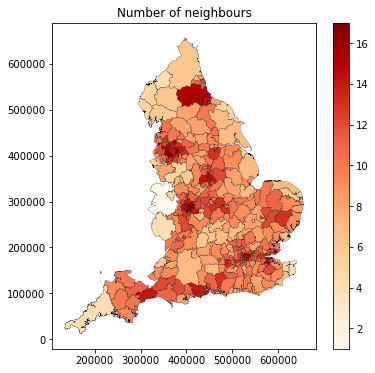

In [18]:
# Sanity check. Plot the number of neighbours to make sure that the final results
# (below) AREA_IDS = [0, 123, 250, 321]
fig, ax = plt.subplots(1, 1, figsize=(6,6))
temp = energy_intensity.copy()
temp['num_neighbours'] = sum(w.full()[0])  # Index 0 has weights matrix, 1 has list of area names
temp.plot(ax=ax, column='num_neighbours', cmap='OrRd', edgecolor='k', alpha=1.0, linewidth=0.2, legend=True)
ax.set_title("Number of neighbours")
#del temp
# XXXX HERE Oh no, results are just reproducing the neighbours!

In [19]:
# Variable of interes
y = energy_intensity.energy_intensity_mean.values

In [20]:
# Applying Getis and Ord local G test using a binary weights object
g = G_Local(y, w, transform='B', star=True)

Can now access the following information (see [pysal docs](https://splot.readthedocs.io/en/stable/users/tutorials/autocorrelation.html#local-autocorrelation)):
 - `g.Gs`: the G* values (an array)
 - `g.p_sim`: simulated p values
 - `lg.p_sim[lg.p_sim<0.05]`: significant G value

In [25]:
# Attach information back to the energy_intensity dataframe
energy_intensity['Gs'] = g.Gs
energy_intensity['Zs'] = g.Zs
energy_intensity['Gs_psig'] = g.p_sim
energy_intensity['Gs_sig'] = g.p_sim<0.05

Plot the GI* values, highlighting significant ones

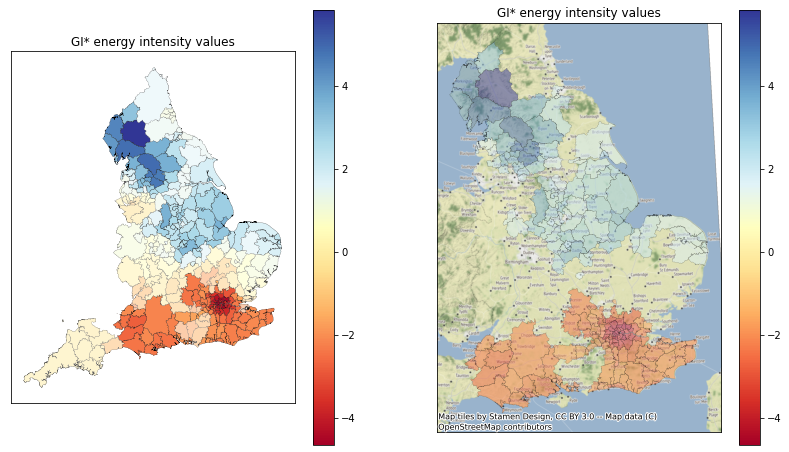

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(14,8))
ax1 = axes[0]
ax2 = axes[1]

# What to map, and colours
# col = 'Gs' # G values
col = 'Zs' # Z values
colour_map = "RdYlBu"
#colour_map = "OrRd"

# Plot without basemap
ax1.set_title("GI* energy intensity values")
energy_intensity.plot(column=col, cmap=colour_map, edgecolor='k', alpha=1.0, 
                      linewidth=0.2, legend=True, ax=ax1)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)

# Mask out non significant
energy_intensity.loc[~energy_intensity.Gs_sig]\
        .plot(alpha=0.5, color="white", edgecolor='k', linewidth=0.0, ax=ax1)

# Plot with basemap (ignoring non significant)
ax2.set_title("GI* energy intensity values")
energy_intensity[energy_intensity.Gs_sig]\
    .plot(column=col, cmap=colour_map, edgecolor='k', alpha=0.5, linewidth=0.2, legend=True, ax=ax2)
cx.add_basemap(ax2, crs=energy_intensity.crs)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
